In [1]:
# Import necessary packages
using PyPlot
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid
using Printf

In [42]:
struct Grid
    x::Vector
    y::Vector
    nx::Int
    ny::Int
    W::Float64
    H::Float64
    dx::Float64
    dy::Float64
    solution::Matrix{Float64}
    rhs::Matrix{Float64}
    residual::Matrix{Float64}
    Grid(W,H,nx,ny) = new(LinRange(0,W,nx),LinRange(0,H,ny),nx,ny,W,H,W/(nx-1),H/(ny-1),zeros(ny,nx),zeros(ny,nx),zeros(ny,nx))
end

function poisson_smoother!(grid::Grid,cycles::Int)
    coef_center = -2/grid.dx^2 -2/grid.dy^2
    coef_right = 1/grid.dx^2
    coef_left = 1/grid.dx^2
    coef_up = 1/grid.dy^2
    coef_down = 1/grid.dy^2
    theta = 1.75;
    cycle = 1
    while cycle <= cycles
        for j in 2:(grid.nx-1)
            for i in 2:(grid.ny-1) # julia is column-major - inner loop over columns
                # in Gauss-Seidel iterations, the solution (s) is updated within each iteration.
                # note that the 1.0 is the (uniform) value of the right hand side, hard-coded for speed.
                this_residual = grid.rhs[i,j] - coef_left*grid.solution[i,j-1] - coef_right*grid.solution[i,j+1] - coef_up*grid.solution[i-1,j] - coef_down*grid.solution[i+1,j] - coef_center*grid.solution[i,j] 
                grid.solution[i,j] += theta*this_residual/coef_center
            end
        end 
        cycle += 1
    end
    for j in 2:(grid.nx-1)
        for i in 2:(grid.ny-1) # julia is column-major - inner loop over columns
            # in Gauss-Seidel iterations, the solution (s) is updated within each iteration.
            # note that the 1.0 is the (uniform) value of the right hand side, hard-coded for speed.
            grid.residual[i,j] = grid.rhs[i,j] - coef_left*grid.solution[i,j-1] - coef_right*grid.solution[i,j+1] - coef_up*grid.solution[i-1,j] - coef_down*grid.solution[i+1,j] - coef_center*grid.solution[i,j] 
        end
    end
end

function poisson_restriction!(fine::Grid,coarse::Grid,mgunit::Int)
    # restriction (fine) -> (coarse)
    coarse.rhs[:,:] = fine.residual[1:mgunit:end,1:mgunit:end]
end

function poisson_prolongation(fine::Grid,coarse::Grid,mgunit::Int)
    dsol = zeros(fine.ny,fine.nx)
    # use bilinear interpolation to go from coarse to fine
    for j in 2:fine.nx-1
        coarse_j = Int( floor( fine.x[j]/coarse.dx )+1 )
        dx = (fine.x[j]-coarse.x[coarse_j])/coarse.dx
        
        for i in 2:fine.ny-1
            coarse_i = Int( floor( fine.y[i]/coarse.dy) + 1)
            dy = (fine.y[i]-coarse.y[coarse_i]) / coarse.dy
            
            dsol[i,j] += (1.0-dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j]
            dsol[i,j] += (1.0-dx)*(dy)*coarse.solution[coarse_i+1,coarse_j]
            dsol[i,j] += (dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j+1]
            dsol[i,j] += (dx)*(dy)*coarse.solution[coarse_i+1,coarse_j+1]
        end
    end
    return dsol
end

poisson_prolongation (generic function with 1 method)

In [43]:
# Test prolongation and restriction operators for a small problem
nx = 7
ny = 10
width = 1e3
height = 1.5e3

# Define levels of grid
nlevel=2
mgunit=3
grids = Vector{Grid}()
cycles = Vector{Int}()
for level in 1:nlevel
    level_nx = Int((nx-1)/mgunit^(level-1)+1)
    level_ny = Int((ny-1)/mgunit^(level-1)+1)
    println(level_nx,' ', level_ny)
    push!(grids, Grid(width,height,level_nx,level_ny) )
    push!(cycles,2^(nlevel-level+1)*5)
end

for i=1:grids[1].ny
    for j in 1:grids[1].nx
        grids[1].residual[i,j] = j^2
    end
end
poisson_restriction!(grids[1],grids[2],mgunit)

show(stdout,"text/plain",grids[1].residual)

show(stdout,"text/plain",grids[2].rhs)

grids[2].solution[:,:] = grids[2].rhs[:,:]
dsol = poisson_prolongation(grids[1],grids[2],mgunit)


7 10
3 4
10×7 Matrix{Float64}:
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.04×3 Matrix{Float64}:
 1.0  16.0  49.0
 1.0  16.0  49.0
 1.0  16.0  49.0
 1.0  16.0  49.0

10×7 Matrix{Float64}:
 0.0  0.0   0.0   0.0   0.0   0.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  0.0   0.0   0.0   0.0   0.0  0.0

In [50]:
# define an indexing function that maps from (i,j) node numbering to an integer index
nx = 513
ny = 1025
width = 1e3
height = 1.5e3

# Define levels of grid
nlevel=7
mgunit=2
grids = Vector{Grid}() # grids to use with multigrid solver
cycles = Vector{Int}() # number of gauss-seidel iterations to take at each multigrid level
for level in 1:nlevel
    level_nx = Int((nx-1)/mgunit^(level-1)+1)
    level_ny = Int((ny-1)/mgunit^(level-1)+1)
    println(level_nx,' ', level_ny)
    push!(grids, Grid(width,height,level_nx,level_ny) )
    push!(cycles,2^(nlevel-level+1)*5)
end

# set RHS for finest grid.
level = 1
for i in 2:grids[level].ny-1
    for j in 2:grids[level].nx-1
        grids[level].rhs[i,j] = 1.0        
    end
end
    
level = 1
outer_cycles = 12
cycle = 1
# outer solver iterations
while cycle <= outer_cycles
    for level in 1:nlevel-1
        if cycle==1 || level > 1 # don't re-run smoother at first level if we're past first cycle.
            poisson_smoother!(grids[level],cycles[level])     
        end
        poisson_restriction!(grids[level],grids[level+1],mgunit)
    end
    # end at grid level nlevel-1
    # compute correction to current solution using a direct solver
    # interpolate corrections onto finer grids
    for level in nlevel:-1:2
        poisson_smoother!(grids[level],cycles[level])
        dsol = poisson_prolongation(grids[level-1],grids[level],mgunit)
        grids[level-1].solution[:,:] += dsol
        # interpolate correction from level+1 onto level
    end
    poisson_smoother!(grids[1],cycles[1]) # run smoother on final (finest) level.  
    println(norm(grids[1].residual))
    cycle += 1 # increment mg cycle counter
end

513 1025
257 513
129 257
65 129
33 65
17 33
9 17
0.03548553092217874
0.07602474134779486
0.06111627170756072
0.020176387214682085
0.002045052250812781
9.551159919412216e-5
3.765087248828873e-5
2.4540379167727647e-6
3.4096457485812905e-7
2.4377593887639317e-8
1.6142860957102277e-8
1.2998508175230058e-8


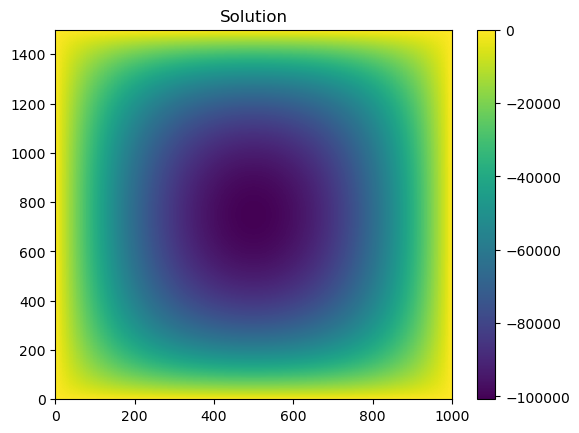

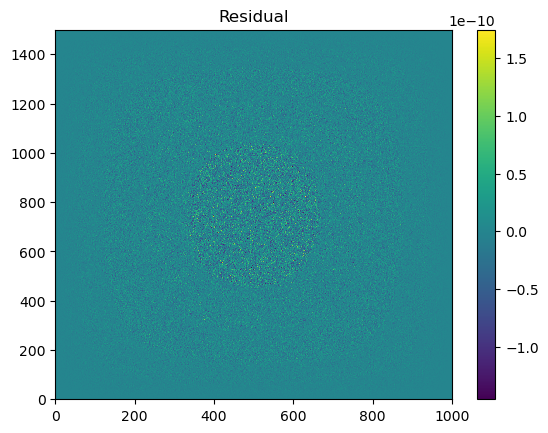

In [51]:
figure()
pcolor(grids[1].x,grids[1].y,grids[1].solution)
colorbar()
title("Solution")
show()
figure()
pcolor(grids[1].x,grids[1].y,grids[1].residual)
colorbar()
title("Residual")
show()